# Lung Cancer Detection

# Problem Definition
Lung cancer is by far the leading cause of cancer death in the United States. According to the American Cancer Society, in 2024 there were about 234,580 new cases of lung cancer (116,310 in men and 118,270 in women) and about 124,070 deaths from lung cancer (65,790 in men and 59,280 in women) in the United States. Lung cancer is the second most common form of cancer in both men and women in the United States as well [1].

Currently, doctors lack the resources to diagnose patients who develop lung cancer with complete accuracy. Although doctors are able to dianose patients in the process of developing lung cancers with relatively high accuracy, hospitals often lack the resources and expertise to diagnose and treat patients holistically due to the ongoing national physician shortage. According to estimates projected by the Association of American Medical Colleges, the United States will face a physician shortage of up to 86,000 physicians by 2036 [2].


Recent advances in machine learning and computer vision have potential to enable systematic advances in medical knowledge and technology and can play a crucial role specifically in advancing imaging technology. State-of-the-art computer vision tools have the ability to classify an assortment of objects in the real world, identify them, classify them, and derive meaningful insights from them [3].

With the Lung and Colon Cancer Histopathological Image dataset on Kaggle [5], the aim of this project is to train several models (3 classical supervised learning algorithms + one or more deep CNNs) in order to predict whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas.

# Project Objectives

## Classification Task

This project's classification task is, from the Lung and Colon Cancer Histopathological Image dataset on Kaggle, train 3 classical machine learning model and 2 deep convolutional neural networks to determine whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas.

## Objectives
### Data Preparation
- Perform exploratory data analysis
- Prepare training, validation, & test data set for:
    - Classical machine learning algorithms
    - Deep learning algorithms

#### Classical Machine Learning
- Train Logistic Regression classifier
- Train K-Nearest Neighbors classifier
- Train Support Vector Machine classifier

#### Deep Learning
- Architect and train Baseline Sequential CNN model
- Finetune Pre-trained Inception-V3 model

# Dataset
## Lung and Colon Cancer Histopathological Images
- 25,000 images of 5 classes including lung and colon cancer and healthy samples
- Images of size 768 x 768 pixels in jpeg format
- HIPAA compliant
### Lung Image Dataset
- 750 original images of lung tissue
  - 250 benign lung tissue
  - 250 lung adenocarcinomas
  - 250 lung squamous cell carcinomas
  - Augmented to 25,0000 images

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

# Data Science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [2]:
# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
# Image processing libraries
import cv2
from PIL import Image
from glob import glob

# Object persistence libraries
import joblib

In [4]:
# Local modules
from utils import make_confusion_matrix

## Data Preparation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/Professional/Education/Graduate/SJSU/CMPE 257 - Machine Learning/Lung Cancer Detection/archive.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


In [7]:
lung_images = "/content/lung_colon_image_set/lung_image_sets"
classes = os.listdir(lung_images)
classes

['lung_aca', 'lung_scc', 'lung_n']

Here, lung_n equates to CT scans of patients with normal lungs, lung_aca equates to CT scans of patients with lung adenocarcinomas, and lung_scc equates to CT scans of patients with lung squamous cell carcinomas.

In [8]:
class_map = {
    "lung_n": "Normal Lungs",
    "lung_aca": "Lung Adenocarcinomas",
    "lung_scc": "Lung Squamous Cell Carcinomas",
}

### Class Distribution

In [9]:
class_counts = {}
for c, condition in class_map.items():
    count = len(os.listdir(f"{lung_images}/{c}"))
    class_counts[condition] = count

class_counts

{'Normal Lungs': 5000,
 'Lung Adenocarcinomas': 5000,
 'Lung Squamous Cell Carcinomas': 5000}

Text(0, 0.5, '# Images')

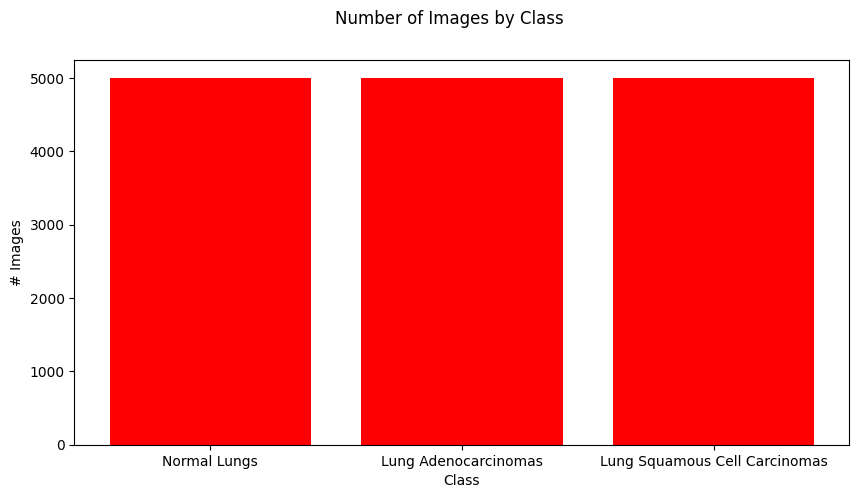

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Number of Images by Class")
ax.bar(class_counts.keys(), class_counts.values(), color="r")
ax.set_xlabel("Class")
ax.set_ylabel("# Images")

From the barplot above, we see that our dataset is well-balanced in terms of the number of samples we have in each class which can be used to train predictive models. Each class (normal lungs, lung adenocarcinomas, lung squamous cell carcinomas) has 5,000 image samples.

### Image Samples

In [11]:
for c, condition in class_map.items():
    images = os.listdir(f"{lung_images}/{c}")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"CT Scan of lungs classified as having {condition}...")

    for i in range(3):
        j = np.random.randint(0, len(images))
        img = np.array(Image.open(f"{lung_images}/{c}/{images[j]}"))
        ax[i].imshow(img)
        ax[i].axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Above, we have plotted 3 image samples from each class just to get a view of the data for which our models will be working with. The most obvious difference between images samples in between the classes is that cell carcinomas (cells with lung adenocarcinomas and cells with lung squamous cell carcinomas) are stained purple while normal lung cells without carcinomas are stained pink. From rudimentary research, cell carcinomas can be properly detected and stained with a variety of methods including immunohistochemistry, H&E staining, dyes binding to cancer cell nuclei, etc..

This may prove to be a crucial feature in predictive analysis; however, cell staining seen in CT scans may not be enough to train a model which can accurately predict whether a CT scan of lung cells contains lung cell carcinomas or not. Let's continue with our EDA and examine what results we get from future predictive analysis.

### Image Dimensions

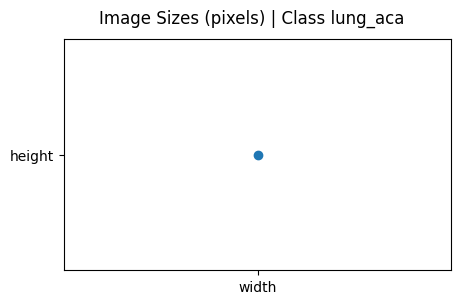

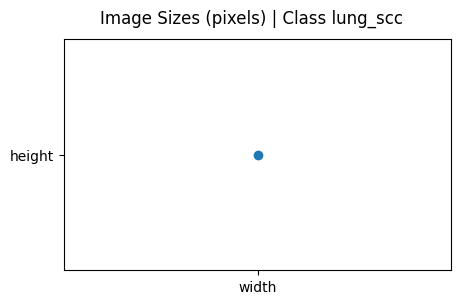

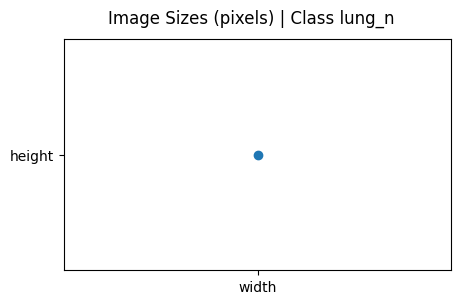

In [12]:
for i, c in enumerate(classes):
    images = glob(f"{lung_images}/{c}/*jpeg")

    fig, ax = plt.subplots(figsize=(5, 3))
    fig.suptitle(f"Image Sizes (pixels) | Class {c}")

    height, width = [], []
    for image in images:
        img = cv2.imread(image)
        h, w, c = img.shape
        height.append(h)
        width.append(w)

    ax.scatter(x="width", y="height")

Here, we see that all images in all classes have image dimensions of 768 pixels (height) x 768 pixels (width). Consistency in image sizes is pertinent when training CNNs for image processing. Our current dataset achieves that; however, let's downsize the images to reduce computation / training time for our image processing models as training a model on 768 x 768 x 3 images can be quite computationally expensive at scale.

### Image Processing / Resizing

In [13]:
IMAGE_SIZE = 224
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [14]:
X_ml = []
y_ml = []
X_dl = []

for i, c in enumerate(class_map.keys()):
    images = glob(f"{lung_images}/{c}/*jpeg")

    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        X_ml.append(img_resized.flatten())
        y_ml.append(i)
        X_dl.append(img_resized)

In [15]:
X_ml = np.array(X_ml)
y_ml = np.array(y_ml)
X_dl = np.array(X_dl)
y_dl = pd.get_dummies(y_ml).values

In [16]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=SPLIT, random_state=50
)
X_train_ml.shape, X_test_ml.shape, y_train_ml.shape, y_test_ml.shape

((12000, 150528), (3000, 150528), (12000,), (3000,))

In [17]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=SPLIT, random_state=50
)
X_train_dl.shape, X_test_dl.shape, y_train_dl.shape, y_test_dl.shape

((12000, 224, 224, 3), (3000, 224, 224, 3), (12000, 3), (3000, 3))

Now that we've finised our exploratory data analysis (EDA) and data preparation, we can move onto predictive analysis. Let's begin with classical machine learning.

## Classical Machine Learning

Classical machine learning models which have performed well for image classification tasks include K-Nearest Neighbors and Support Vector Machine.

Historically, a classical machine learning model generally not well-suited for image classification tasks is Logistic Regression. Logistic Regression is thought to not perform well on image classification tasks as images are typically high-dimension which make Logistic Regression less effective. Image features also exhibit non-linear relationships which Logistic Regression models have a hard time of capturing.


K-Nearest Neighbors models are thought to be effective for image classification tasks as the K-Nearest Neighbors algorithm can extract spatial features which may be present in image data. K-Nearest Neighbors models are thought to be able to capture non-linear relationships on trained data due to the spatial nature of the algorithm.

Support Vector Machines tend to be yet more effective for image classification tasks as SVMs can handle high-dimensional feature vectors which are common in image classification datasets, can capture non-linear relationships especially when using non-linear kernels, and tend to generalize well overall.

In this project, I aim to train various Logistic Regression, K-Nearest Neighbor, and Support Vector Machine models, evaluate their respective classification accuracy metrics, and offer analysis on which model seemed to perform best on my image classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas given an image of a CT scan of the patient's lungs.

### Logistic Regression

Let's begin with training a few Logistic Regression Models using Scikit-Learn's Stochastic Gradient Descent Classifier with a logistic loss function.

We'll start with a Logistic Regression model trained using L1 regularization (Lasso Regression).

#### L1 Regularization (Lasso Regression)

In [ ]:
sgd_clf_l1 = SGDClassifier(
    loss='log_loss',
    penalty='l1',
    n_jobs=-1
)
sgd_clf_l1.fit(X_train_ml, y_train_ml)

In [ ]:
sgd_clf_l1_pred_train = cross_val_predict(
    estimator=clone(sgd_clf_l1),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_l1_pred_train

array([1, 2, 2, ..., 1, 1, 2])

In [ ]:
cf_sgd_clf_l1_train = confusion_matrix(y_train_ml, sgd_clf_l1_pred_train)
cf_sgd_clf_l1_train

array([[3817,  103,   53],
       [ 128, 2477, 1393],
       [   4, 1106, 2919]])

In [35]:
categories = ["Zero", "One", "Two"]

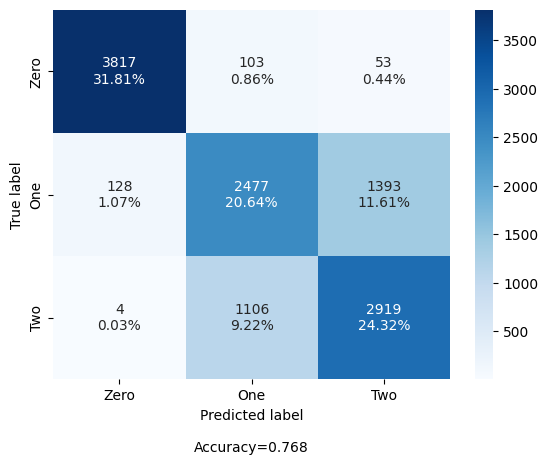

In [ ]:
make_confusion_matrix(cf_sgd_clf_l1_train, categories=categories, cmap="Blues")

Above we've trained a Stochastic Gradient Descent Classifier with a loss function similar to that of a logistic regression model, essentially making this a Logistic Regression Probabilistic Classifier, on our lung cancer image dataset. We trained our classifier using L1 regularization (Lasso Regression), a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of 0.762.

Let's examine how our Logistic Regression Probabilistic Classifier w/ L1 regularization performs on unseen CT scans of patients' lungs.

In [ ]:
sgd_clf_l1_pred_test = sgd_clf_l1.predict(X_test_ml)

In [ ]:
sgd_clf_l1_pred_test = cross_val_predict(
    estimator=clone(sgd_clf_l1),
    X=X_test_ml,
    y=y_test_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_l1_pred_test

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
cf_sgd_clf_l1_test = confusion_matrix(y_test_ml, sgd_clf_l1_pred_test)
cf_sgd_clf_l1_test

array([[981,  36,  10],
       [ 35, 555, 412],
       [  2, 310, 659]])

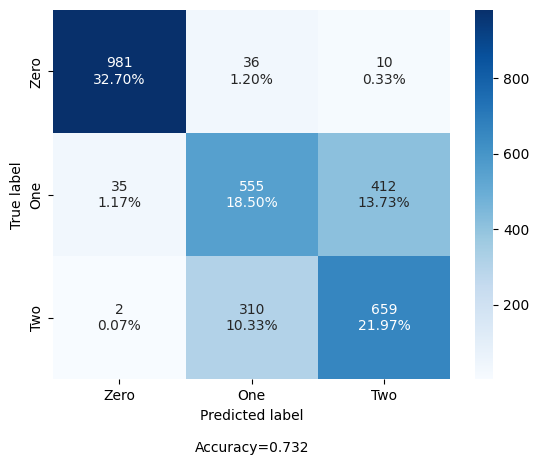

In [ ]:
make_confusion_matrix(cf_sgd_clf_l1_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ L1 regularization achieves a test accuracy of 0.765 on the test dataset.

From the get go, considering Logistic Regression Classifiers were historically known to not be well-suited for image classification tasks it seems our Logistic Regression Classifier w/ L1 regularization performs relatively well.

Let's train a few more Logistic Regression Clasifiers with different hyperparameters to come to a more well-rounded conclusion.

#### L2 Regularization - Ridge Regression

In [ ]:
sgd_clf_l2 = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    n_jobs=-1
)
sgd_clf_l2.fit(X_train_ml, y_train_ml)

SGDClassifier(loss='log_loss', n_jobs=-1)

In [ ]:
sgd_clf_l2_pred_train = cross_val_predict(
    estimator=clone(sgd_clf_l2),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_l2_pred_train

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
cf_sgd_clf_l2_pred_train = confusion_matrix(y_train_ml, sgd_clf_l2_pred_train)
cf_sgd_clf_l2_pred_train

array([[3830,   95,   48],
       [  93, 2035, 1870],
       [   4,  711, 3314]])

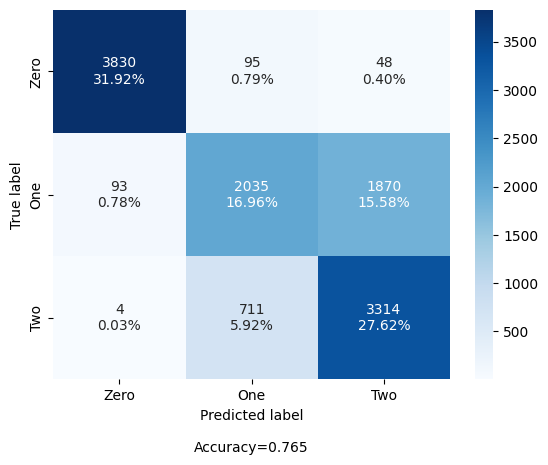

In [ ]:
make_confusion_matrix(cf_sgd_clf_l2_pred_train, categories=categories, cmap="Blues")

Above we've trained another Logistic Regression Probabilistic Classifier on our lung cancer training image dataset. This time, we trained our classifier using L2 regularization (Ridge Regression), a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of 0.765.

Let's examine how our Logistic Regression Probabilistic Classifier w/ L2 regularization performs on unseen data.

In [ ]:
sgd_clf_l2_pred_test = sgd_clf_l2.predict(X_test_ml)

In [ ]:
cf_sgd_clf_l2_pred_test = confusion_matrix(y_test_ml, sgd_clf_l2_pred_test)
cf_sgd_clf_l2_pred_test

array([[982,  33,  12],
       [ 17, 642, 343],
       [  0, 234, 737]])

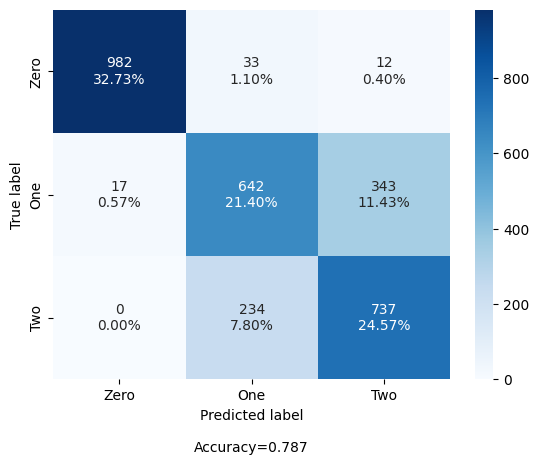

In [ ]:
make_confusion_matrix(cf_sgd_clf_l2_pred_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ L2 regularization achieves a test accuracy of 0.787 on the test dataset.

With L2 Regularization, we seem to achieve a slightly better test accuracy on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Let's train one last Logistic Regression Classifier using a combination of L1 and L2 regularization, Elastic net regularization.

#### Elastic Net Regularization

In [ ]:
sgd_clf_elasticnet = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    n_jobs=-1
)
sgd_clf_elasticnet.fit(X_train_ml, y_train_ml)

SGDClassifier(loss='log_loss', n_jobs=-1, penalty='elasticnet')

In [ ]:
sgd_clf_elasticnet_pred_train = cross_val_predict(
    estimator=clone(sgd_clf_elasticnet),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_elasticnet_pred_train

array([1, 2, 2, ..., 1, 2, 2])

In [ ]:
cf_sgd_clf_elasticnet_pred_train = confusion_matrix(y_train_ml, sgd_clf_elasticnet_pred_train)
cf_sgd_clf_elasticnet_pred_train

array([[3841,  108,   24],
       [ 135, 2412, 1451],
       [  13, 1167, 2849]])

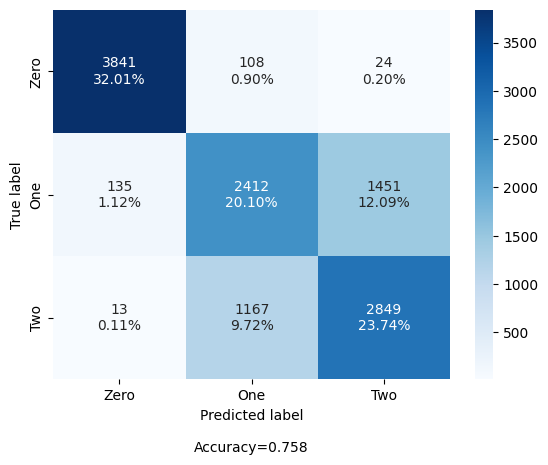

In [ ]:
make_confusion_matrix(cf_sgd_clf_elasticnet_pred_train, categories=categories, cmap="Blues")

We've trained a last Logistic Regression Probabilistic Classifier on our lung cancer training image dataset. This classifier was trained using Elastic net regularization, a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of 0.758.

Let's examine how our Logistic Regression Probabilistic Classifier w/ Elastic net regularization performs on unseen data.

In [ ]:
sgd_clf_elasticnet_pred_test = sgd_clf_elasticnet.predict(X_test_ml)

In [ ]:
cf_sgd_clf_elasticnet_pred_test = confusion_matrix(y_test_ml, sgd_clf_elasticnet_pred_test)
cf_sgd_clf_elasticnet_pred_test

array([[1011,   10,    6],
       [  56,  578,  368],
       [   8,  188,  775]])

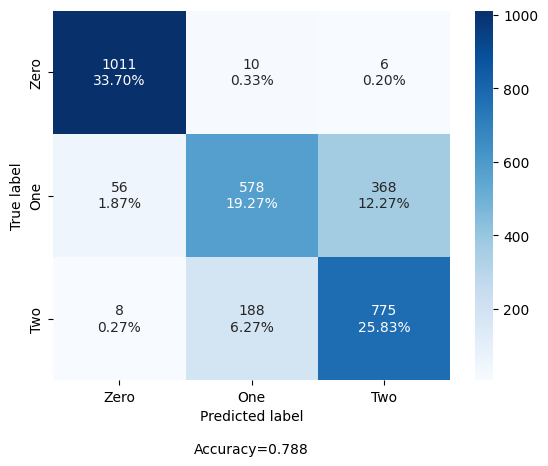

In [ ]:
make_confusion_matrix(cf_sgd_clf_elasticnet_pred_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ Elastic net regularization achieves a test accuracy of 0.788 on the test dataset.

With Elastic net Regularization, we seem to achieve a similar test accuracy on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs compared to L2 regularization.

Now, with just a small hyperparameter space, let's use GridSearch Cross-validation to exhaustively determine what is the optimal set of hyperparameters among the hyperparameter space for a Logistic Regression classifier for this classification task.

#### Optimal Hyperparameter Search

In [ ]:
sgd_clf = SGDClassifier(loss='log_loss')

In [ ]:
sgd_clf_parameters = {
    "penalty": ["l1", "l2", "elasticnet"]
}

In [ ]:
sgd_clf_best = GridSearchCV(sgd_clf, sgd_clf_parameters, cv=3, scoring="accuracy",
                            n_jobs=-1)
sgd_clf_best.fit(X_train_ml, y_train_ml)

GridSearchCV(cv=3, estimator=SGDClassifier(loss='log_loss'), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

In [ ]:
sgd_clf_gridsearch_res = pd.DataFrame(sgd_clf_best.cv_results_)
sgd_clf_gridsearch_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3258.945418,409.181778,0.488171,0.037590,l1,{'penalty': 'l1'},0.76650,0.77675,0.76400,0.769083,0.005516,2
1,2410.214415,9.091972,1.155497,0.609215,l2,{'penalty': 'l2'},0.77325,0.78775,0.75925,0.773417,0.011636,1
2,2510.422789,24.051203,0.589128,0.082874,elasticnet,{'penalty': 'elasticnet'},0.77525,0.75875,0.77100,0.768333,0.006995,3


In [ ]:
sgd_clf_best.best_params_

{'penalty': 'l2'}

In [ ]:
sgd_clf_best.best_score_

0.7734166666666665

In [ ]:
sgd_clf_best_pred_test = sgd_clf_best.predict(X_test_ml)

In [ ]:
cf_sgd_clf_best_pred_test = confusion_matrix(y_test_ml, sgd_clf_best_pred_test)
cf_sgd_clf_best_pred_test

array([[945,  70,  12],
       [  2, 703, 297],
       [  0, 300, 671]])

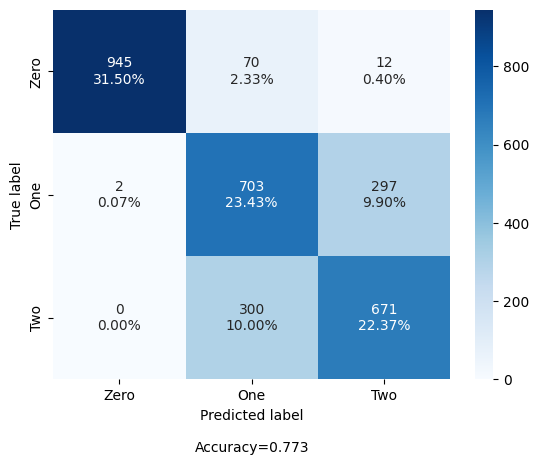

In [ ]:
make_confusion_matrix(cf_sgd_clf_best_pred_test, categories=categories, cmap="Blues")

After running GridSearch with 3 cross-validation folds on the above hyperparameter space, we find that GridSearch determined the most optimal set of hyperparameters for Logistic Regression classification for this classification task was one with L2 regularization.

Our optimally tuned Logistic Regression classifier w/ L2 regularization achieved a test accuracy of 0.773.

Overall, albeit being historically known to not be well-suited for image classification tasks, our Logistic Regression Classifier w/ L2 regularization performed fairly well on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Let's examine how K-Nearest Neighbors classifiers do on this image classification task.

In [ ]:
# Save the SGD Classifier model
joblib.dump(sgd_clf_best, "models/sgd/sgd_best.pkl")

['models/sgd/sgd_best.pkl']

### K-Nearest Neighbors

#### KNN with K = 5

In [ ]:
# K-Nearest Neighbors with K = 5
knn5 = KNeighborsClassifier(n_jobs=-1)
knn5.fit(X_train_ml, y_train_ml)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
knn5_pred_train = cross_val_predict(
    estimator=clone(knn5),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
knn5_pred_train

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
cf_knn5_pred_train = confusion_matrix(y_train_ml, knn5_pred_train)
cf_knn5_pred_train

array([[2284, 1224,  465],
       [   1,  203, 3794],
       [   0,    1, 4028]])

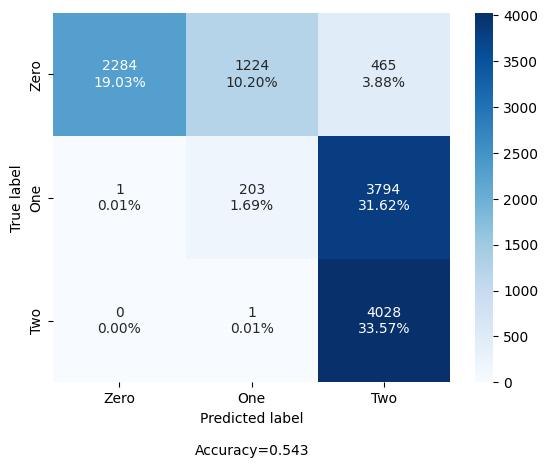

In [ ]:
make_confusion_matrix(cf_knn5_pred_train, categories=categories, cmap="Blues")

Here, we've trained a K-Nearest Neighbors Classifier with K = 5. a We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of 0.543.

Interestingly enough, our K-Nearest Neighbors Classifier achieves a lower validation accuracy than that of our Logistic Regression models by a margin. While Logistic Regression was thought to perform poorly at image classification and K-Nearest Neighbors was thought to perform well, we see the opposite in which our K-Nearest Neighbors model performs significantly worse in terms of validation accuracy.

Let's examine how our K-Nearest Neighbors Classifier with K = 5 performs on unseen data to come to a better conclusion.

In [ ]:
knn5_pred = knn5.predict(X_test_ml)

In [ ]:
cf_knn5 = confusion_matrix(y_test_ml, knn5_pred)
cf_knn5

array([[561, 349, 117],
       [  0,  70, 932],
       [  0,   1, 970]])

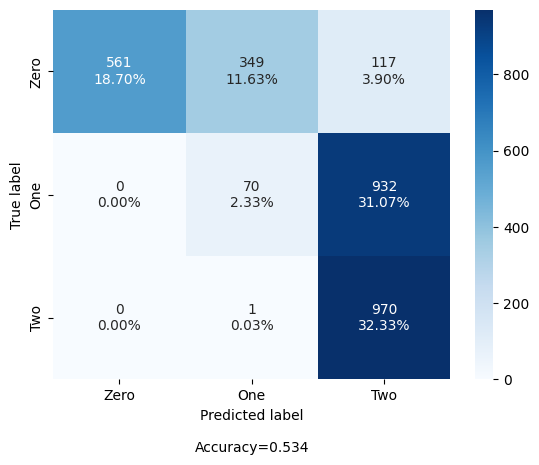

In [ ]:
make_confusion_matrix(cf_knn5, categories=categories, cmap="Blues")

Here, we see that our K-Nearest Neighbors Classifier with K = 5 achieves a test accuracy of 0.534 on the test dataset. It seems our test accuracy had not risen much since our validation accuracy on this image classification task for our K-Nearest Neighbors model.

While it may seem like our K-Nearest Neighbors model underperforms in image classification when compared to Logistic Regression, let's try training another K-Nearest Neighbors Classifier with different hyperparameters to come to a more well-rounded conclusion.

#### KNN with K = 3

In [ ]:
# K-Nearest Neighbors with N = 3
knn3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn3.fit(X_train_ml, y_train_ml)


KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [ ]:
knn3_pred_train = cross_val_predict(
    estimator=clone(knn3),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
knn3_pred_train

python(45225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45237) Malloc

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
cf_knn3_pred_train = confusion_matrix(y_train_ml, knn3_pred_train)
cf_knn3_pred_train

array([[2400, 1174,  399],
       [   1,  468, 3529],
       [   0,    8, 4021]])

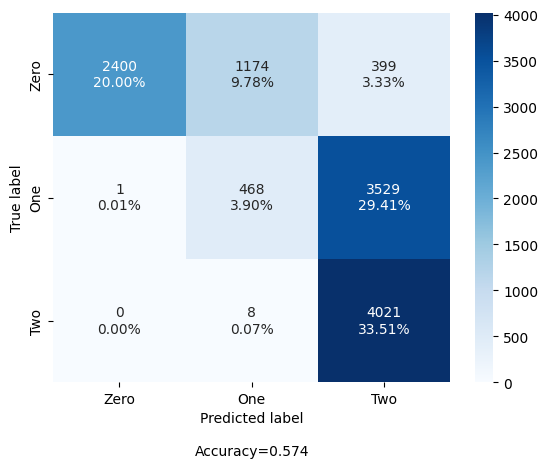

In [ ]:
make_confusion_matrix(cf_knn3_pred_train, categories=categories, cmap="Blues")

Above we've trained a K-Nearest Neighbors Classifier with K = 3. a We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of 0.574.

Let's examine how our K-Nearest Neighbors Classifier w/ K = 3 performs on unseen data.

In [ ]:
knn3_pred = knn3.predict(X_test_ml)

In [ ]:
cf_knn3 = confusion_matrix(y_test_ml, knn3_pred)
cf_knn3

array([[624, 305,  98],
       [  0, 182, 820],
       [  0,   1, 970]])

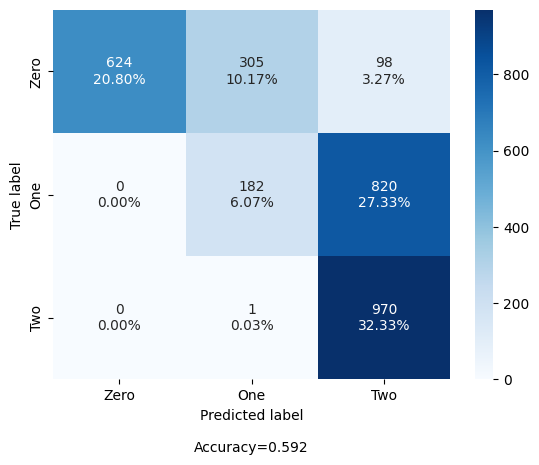

In [ ]:
make_confusion_matrix(cf_knn3, categories=categories, cmap="Blues")

Here, we see that our K-Nearest Neighbors Classifier with K = 3 achieves a test accuracy of 0.592 on the test dataset. We see a slight increase in test accuracy from our KNN model with K = 5 though this is still suboptimal performance.

Let's try training a K-Nearest Neighbors Classifier with K = 4 as a middle ground.

#### KNN with K = 4

In [ ]:
# Load K-Nearest Neighbors with N = 4 model from pkl file
knn4 = joblib.load("models/knn/knn4.pkl")
knn4

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# K-Nearest Neighbors with N = 4
knn4 = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn4.fit(X_train_ml, y_train_ml)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4)

In [ ]:
knn4_pred_train = cross_val_predict(
    estimator=clone(knn4),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
knn4_pred_train

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
cf_knn4_pred_train = confusion_matrix(y_train_ml, knn4_pred_train)
cf_knn4_pred_train

array([[2665,  902,  406],
       [   1,  500, 3497],
       [   0,   14, 4015]])

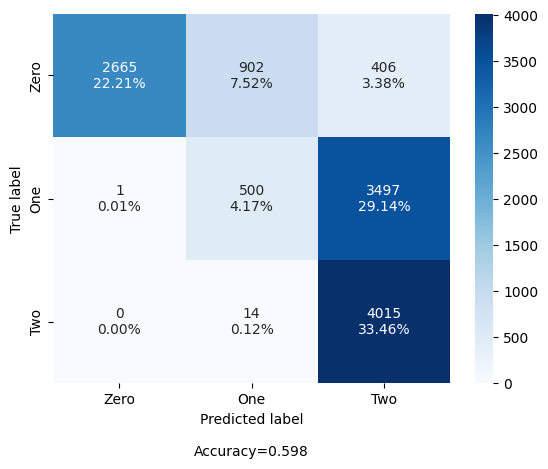

In [ ]:
make_confusion_matrix(cf_knn4_pred_train, categories=categories, cmap="Blues")

Above we've trained a K-Nearest Neighbors Classifier with N Neighbors = 4. We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of .

Let's examine how our K-Nearest Neighbors Classifier performs on unseen data.

In [ ]:
knn4_pred = knn4.predict(X_test_ml)
knn4_pred

array([2, 0, 2, ..., 2, 0, 2])

In [ ]:
cf_knn4 = confusion_matrix(y_test_ml, knn4_pred)
cf_knn4

array([[674, 255,  98],
       [  0, 193, 809],
       [  0,   4, 967]])

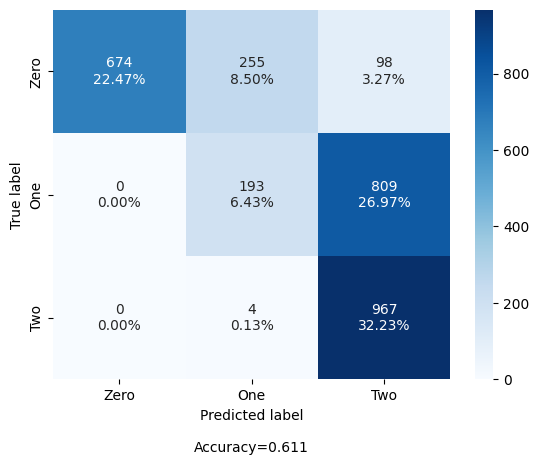

In [ ]:
make_confusion_matrix(cf_knn4, categories=categories, cmap="Blues")

Here, we see that our K-Nearest Neighbors Classifier with K = 4 achieves a test accuracy of 0.611 on the test dataset. Although we see improvement in our test accuracy from that of our K-Nearest Neighbors model trained with K = 3 and K = 5, our K-Nearest Neighbors Classifier with K = 4 doesn't seem to perform well for this classification task.

Let's see if we can find a better set of hyperparameters for a K-Nearest Neighobors classifier for this classification task using GridSearchCV.

#### Optimal Hyperparameter Search

In [ ]:
knn_best = KNeighborsClassifier()

In [ ]:
knn_parameters = {
    "n_neighbors": list(range(1, 10))
}

In [ ]:
knn_best = GridSearchCV(knn_best, knn_parameters, cv=3, scoring="accuracy",
                            n_jobs=-1)
knn_best.fit(X_train_ml, y_train_ml)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [ ]:
knn_best_gridsearch_res = pd.DataFrame(knn_best.cv_results_)
knn_best_gridsearch_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.255651,0.024042,180.186349,21.013067,1,{'n_neighbors': 1},0.68400,0.68650,0.71700,0.695833,0.015002,2
1,0.248149,0.009623,191.400552,5.445124,2,{'n_neighbors': 2},0.70600,0.71175,0.73750,0.718417,0.013697,1
2,0.234282,0.004447,191.288604,5.630950,3,{'n_neighbors': 3},0.55850,0.56050,0.60325,0.574083,0.020640,4
3,0.251819,0.033419,191.113555,5.595984,4,{'n_neighbors': 4},0.58275,0.58100,0.63125,0.598333,0.023287,3
4,0.725379,0.831271,155.583046,13.939657,5,{'n_neighbors': 5},0.52750,0.51875,0.58250,0.542917,0.028217,8
5,0.357645,0.305270,158.965772,4.777481,6,{'n_neighbors': 6},0.54950,0.54225,0.60650,0.566083,0.028732,5
6,0.150294,0.013611,150.741477,1.358662,7,{'n_neighbors': 7},0.52075,0.51300,0.59025,0.541333,0.034734,9
7,0.828811,0.423590,147.126102,2.667486,8,{'n_neighbors': 8},0.54075,0.53500,0.60425,0.560000,0.031377,6
8,0.200912,0.029712,1586.415821,974.501710,9,{'n_neighbors': 9},0.52300,0.51500,0.59325,0.543750,0.035154,7


In [ ]:
knn_best.best_params_

{'n_neighbors': 2}

In [ ]:
knn_best.best_score_

0.7184166666666666

In [ ]:
knn_best_pred_test = knn_best.predict(X_test_ml)

In [ ]:
cf_knn_best_pred_test = confusion_matrix(y_test_ml, knn_best_pred_test)
cf_knn_best_pred_test

array([[819, 157,  51],
       [  0, 474, 528],
       [  0,   6, 965]])

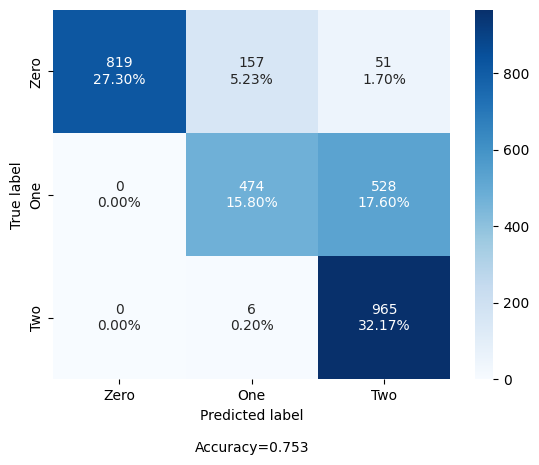

In [ ]:
make_confusion_matrix(cf_knn_best_pred_test, categories=categories, cmap="Blues")

After running GridSearch with 3 cross-validation folds on the above hyperparameter space, we find that GridSearch determined the most optimal set of hyperparameters for K-Nearest Neighbors classification for this classification task was one with K = 2.

Our optimally tuned K-Nearest Neighbors classifier w K = 2 achieved a test accuracy of 0.753 which is a significant improvement from our K-Nearest Neighbor classifiers we've trained above.

Nonetheless, after training several K-Nearest Neighbors Classifiers and performing GridSearch over a small set of hyperparameters, we see that the K-Nearest Neighbors algorithm generally does not perform as well on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs as Logistic Regression classification.

Let's try seeing how Support Vector Classifiers do on this image classification task.

In [ ]:
# Save the SGD Classifier model
joblib.dump(knn_best, "models/knn/knn_best.pkl")

['models/knn/knn_best.pkl']

### Support Vector Machine

#### Linear Kernel SVC

In [ ]:
lin_kernel_svc = Pipeline(
    [("Scaler", StandardScaler()), ("svm_clf", SVC(kernel="linear", C=5))]
)
lin_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, kernel='linear'))])

In [ ]:
lin_kernel_svc_pred_train = cross_val_predict(
    estimator=clone(lin_kernel_svc),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
lin_kernel_svc_pred_train

python(45888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(45900) Malloc

array([1, 2, 2, ..., 1, 1, 1])

In [ ]:
cf_knn4_pred_train = confusion_matrix(y_train_ml, knn4_pred_train)
cf_knn4_pred_train

array([[2665,  902,  406],
       [   1,  500, 3497],
       [   0,   14, 4015]])

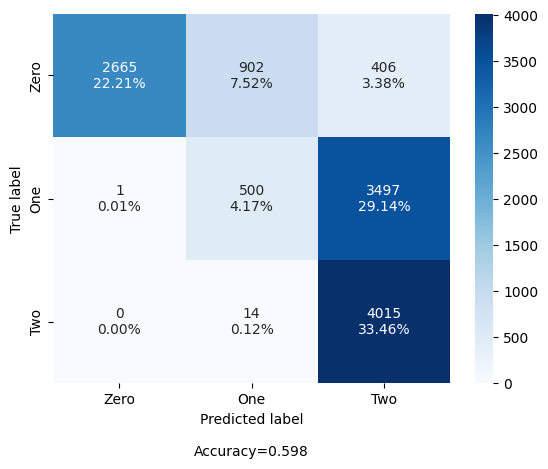

In [ ]:
make_confusion_matrix(cf_knn4_pred_train, categories=categories, cmap="Blues")

Here, we've trained a Support Vector Classifier with a linear kernel. a We trained this classifier using a C regularization parameter of 1.0, shrinking heuristic, and one-vs-rest decision function. With this model, we achieve a validation accuracy of 0.598.

Let's examine how our Support Vector Classifier with a linear kernel performs on unseen data.

In [ ]:
lin_kernel_svc_pred_test = lin_kernel_svc.predict(X_test_ml)
lin_kernel_svc_pred_test

array([1, 0, 0, ..., 2, 0, 1])

In [ ]:
cf_lin_kernel_svc = confusion_matrix(y_test_ml, lin_kernel_svc_pred_test)
cf_lin_kernel_svc

array([[1001,   23,    3],
       [  28,  619,  355],
       [   2,  241,  728]])

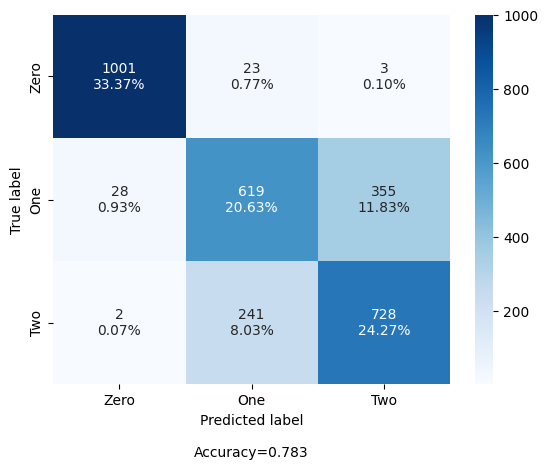

In [ ]:
make_confusion_matrix(cf_lin_kernel_svc, categories=categories, cmap="Blues")

Here, we see that our Support Vector Classifier with a linear kernel achieves a test accuracy of 0.783 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

This is a significant improvement from our K-Nearest Neighbor Classifiers yet again an underperformance since our Logistic Regression Classifiers. Let's try to see if we can perform better by training Support Vector Classifiers with non-linear kernels as non-linear kernels may fit image data better than linear kernels.

#### Polynomial Kernel SVC

In [ ]:
poly_kernel_svc = Pipeline(
    [
        ("Scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ]
)
poly_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [ ]:
poly_kernel_svc_pred_test = poly_kernel_svc.predict(X_test_ml)
poly_kernel_svc_pred_test

array([1, 0, 0, ..., 2, 0, 2])

In [ ]:
cf_poly_kernel_svc_pred_test = confusion_matrix(y_test_ml, poly_kernel_svc_pred_test)
cf_poly_kernel_svc_pred_test

array([[1009,   16,    2],
       [   4,  787,  211],
       [   0,   47,  924]])

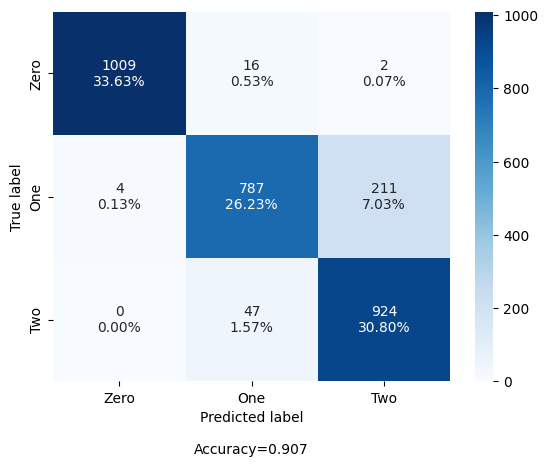

In [ ]:
make_confusion_matrix(cf_poly_kernel_svc_pred_test, categories=categories, cmap="Blues")

Here, we see that our Support Vector Classifier with a polynomial kernel achieves a test accuracy of 0.907 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Again, we see a significant performance from our previous (and fairly performant) Support Vector Classifier trained with a linear kernel.

#### Guassian RBF Kernel SVC

In [ ]:
rbf_kernel_svc = Pipeline(
    [("scaler", StandardScaler()), ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))]
)
rbf_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
rbf_kernel_svc_pred_test = rbf_kernel_svc.predict(X_test_ml)
rbf_kernel_svc_pred_test

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
cf_rbf_kernel_svc_pred_test = confusion_matrix(y_test_ml, rbf_kernel_svc_pred_test)
cf_rbf_kernel_svc_pred_test

array([[   0,    0, 1027],
       [   0,    0, 1002],
       [   0,    0,  971]])

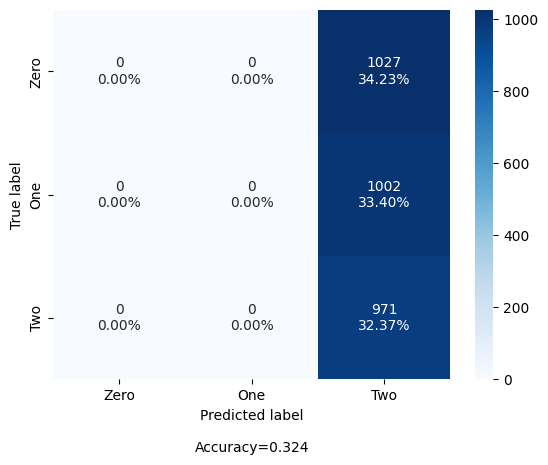

In [ ]:
make_confusion_matrix(cf_rbf_kernel_svc_pred_test, categories=categories, cmap="Blues")

Here, we see that our Support Vector Classifier with a Guassian RBF kernel achieves a test accuracy of 0.324. Our Support Vector Classifier with a Guassian RBF kernel yielded a significant decrease in performance in comparison to our previous Support Vector Classifier with polynomial kernel. Interestingly enough, from an examination of our confusion matrix above, it seems our Support Vector Classifier with a Guassian RBF kernel classified all of the test examples as lungs with lung squamous cell carcinomas. Perhaps some further scrutiny must be done to determine whether the Guassian RBF kernel is sensitive to imbalances in data / overfits significantly to subsets of the dataset.

Let's see if we can find a better set of hyperparameters for a Support Vector Machine classifier for this classification task using GridSearchCV.

#### Optimal Hyperparameter Search

In [ ]:
svc_best = SVC()

In [ ]:
svc_parameters = {
    "kernel": ["linear", "poly", "rbf"],
    "C": [5, 5, 0.001]
}

In [ ]:
svc_best = GridSearchCV(svc_best, svc_parameters, cv=3, scoring="accuracy")
svc_best.fit(X_train_ml, y_train_ml)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [5, 5, 0.001],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [ ]:
svc_best_gridsearch_res = pd.DataFrame(svc_best.cv_results_)
svc_best_gridsearch_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,202.388363,18.590235,99.654487,8.298030,5.000,linear,"{'C': 5, 'kernel': 'linear'}",0.77725,0.77625,0.76775,0.773750,0.004262,6
1,186.138220,1.888176,97.135323,1.520130,5.000,poly,"{'C': 5, 'kernel': 'poly'}",0.83275,0.83400,0.82600,0.830917,0.003514,3
2,125.665029,3.582595,1057.643273,1188.486224,5.000,rbf,"{'C': 5, 'kernel': 'rbf'}",0.91550,0.91200,0.91525,0.914250,0.001594,1
3,185.484816,14.974806,90.786756,1.421745,5.000,linear,"{'C': 5, 'kernel': 'linear'}",0.77725,0.77625,0.76775,0.773750,0.004262,6
4,800.942482,440.683814,423.628581,467.873149,5.000,poly,"{'C': 5, 'kernel': 'poly'}",0.83275,0.83400,0.82600,0.830917,0.003514,3
5,1053.224417,37.090997,1858.113089,503.434109,5.000,rbf,"{'C': 5, 'kernel': 'rbf'}",0.91550,0.91200,0.91525,0.914250,0.001594,1
6,1536.031622,390.907692,413.694418,458.371746,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.77725,0.77625,0.76775,0.773750,0.004262,6
7,807.281349,303.139484,753.625971,466.965377,0.001,poly,"{'C': 0.001, 'kernel': 'poly'}",0.79550,0.80025,0.78875,0.794833,0.004718,5
8,1650.521203,1630.325225,1286.230412,1130.201894,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",0.64475,0.64750,0.64575,0.646000,0.001137,9


In [ ]:
svc_best.best_params_

{'C': 5, 'kernel': 'rbf'}

In [ ]:
svc_best.best_score_

0.91425

In [ ]:
svc_best_pred_test = svc_best.predict(X_test_ml)

In [ ]:
cf_svc_best_pred_test = confusion_matrix(y_test_ml, svc_best_pred_test)
cf_svc_best_pred_test

array([[1008,   19,    0],
       [   3,  880,  119],
       [   0,   93,  878]])

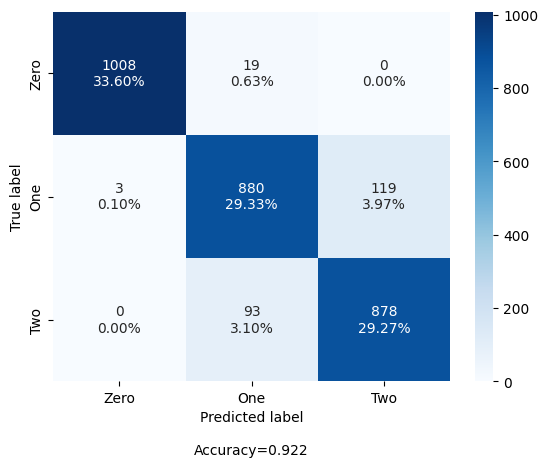

In [ ]:
make_confusion_matrix(cf_svc_best_pred_test, categories=categories, cmap="Blues")

After running GridSearch with 3 cross-validation folds on the above hyperparameter space, we find that GridSearch determined the most optimal set of hyperparameters for Support Vector Machine classification for this classification task was one with kernel = 'rbf' and C = 5.

Our optimally tuned Support Vector Machine classifier w kernel = 'rbf' and C = 5 achieved a whopping test accuracy of 0.922 which could be a potential candidate for an computer-aided diagnostic tool for lung cancer detection.

One thing to note here is that in our previous Support Vector Machine classification model trained with kernel = 'rbf' but C = 0.001, we witnessed an underperformance for our classification task yielding a test accuracy of 0.324. Through GridSearchCV, we've found a model which yields a 0.922 which uses the same kernel = 'rbf' but uses a C = 5. The Support Vector Machine model with C = 0.001 most likely had a soft margin which was too large and ended up predicting all observations as label 2 (lungs w/ lung squamous cell carcinomas). By increasing C to C = 5, our SVM is able to differentiate between the classes more effectively and achieve the high levels of test accuracy that we see above.

In [ ]:
# Save the SGD Classifier model
joblib.dump(svc_best, "models/svc/svc_best.pkl")

['models/svc/svc_best.pkl']

### Results

Overall, out of all the classical machine learning models we've trained from Scikit-Learn's library, we find that our K-Nearest Neighbor models performed the poorest, our Logistic Regression models performed in between, and our Support Vector Machine Classifier models performed well on our image classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs, achieving a peak test accuracy of 0.922.

As this section comes to a close, training machine learning classifiers for image classification, a new chapter begins. In the next section of this project, I aim to train several Convolutional Neural Networks (CNNs) which are reknown for their effectiveness in complex image classification tasks and Computer Vision.

## Deep Learning

### Basic Sequential CNN Architecture

In [18]:
sequential_cnn = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMAGE_SIZE,
                               IMAGE_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [19]:
sequential_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,819,971 (98.50 MB)

 Trainable params: 25,819,203 (98.49 MB)

 Non-trainable params: 768 (3.00 KB)

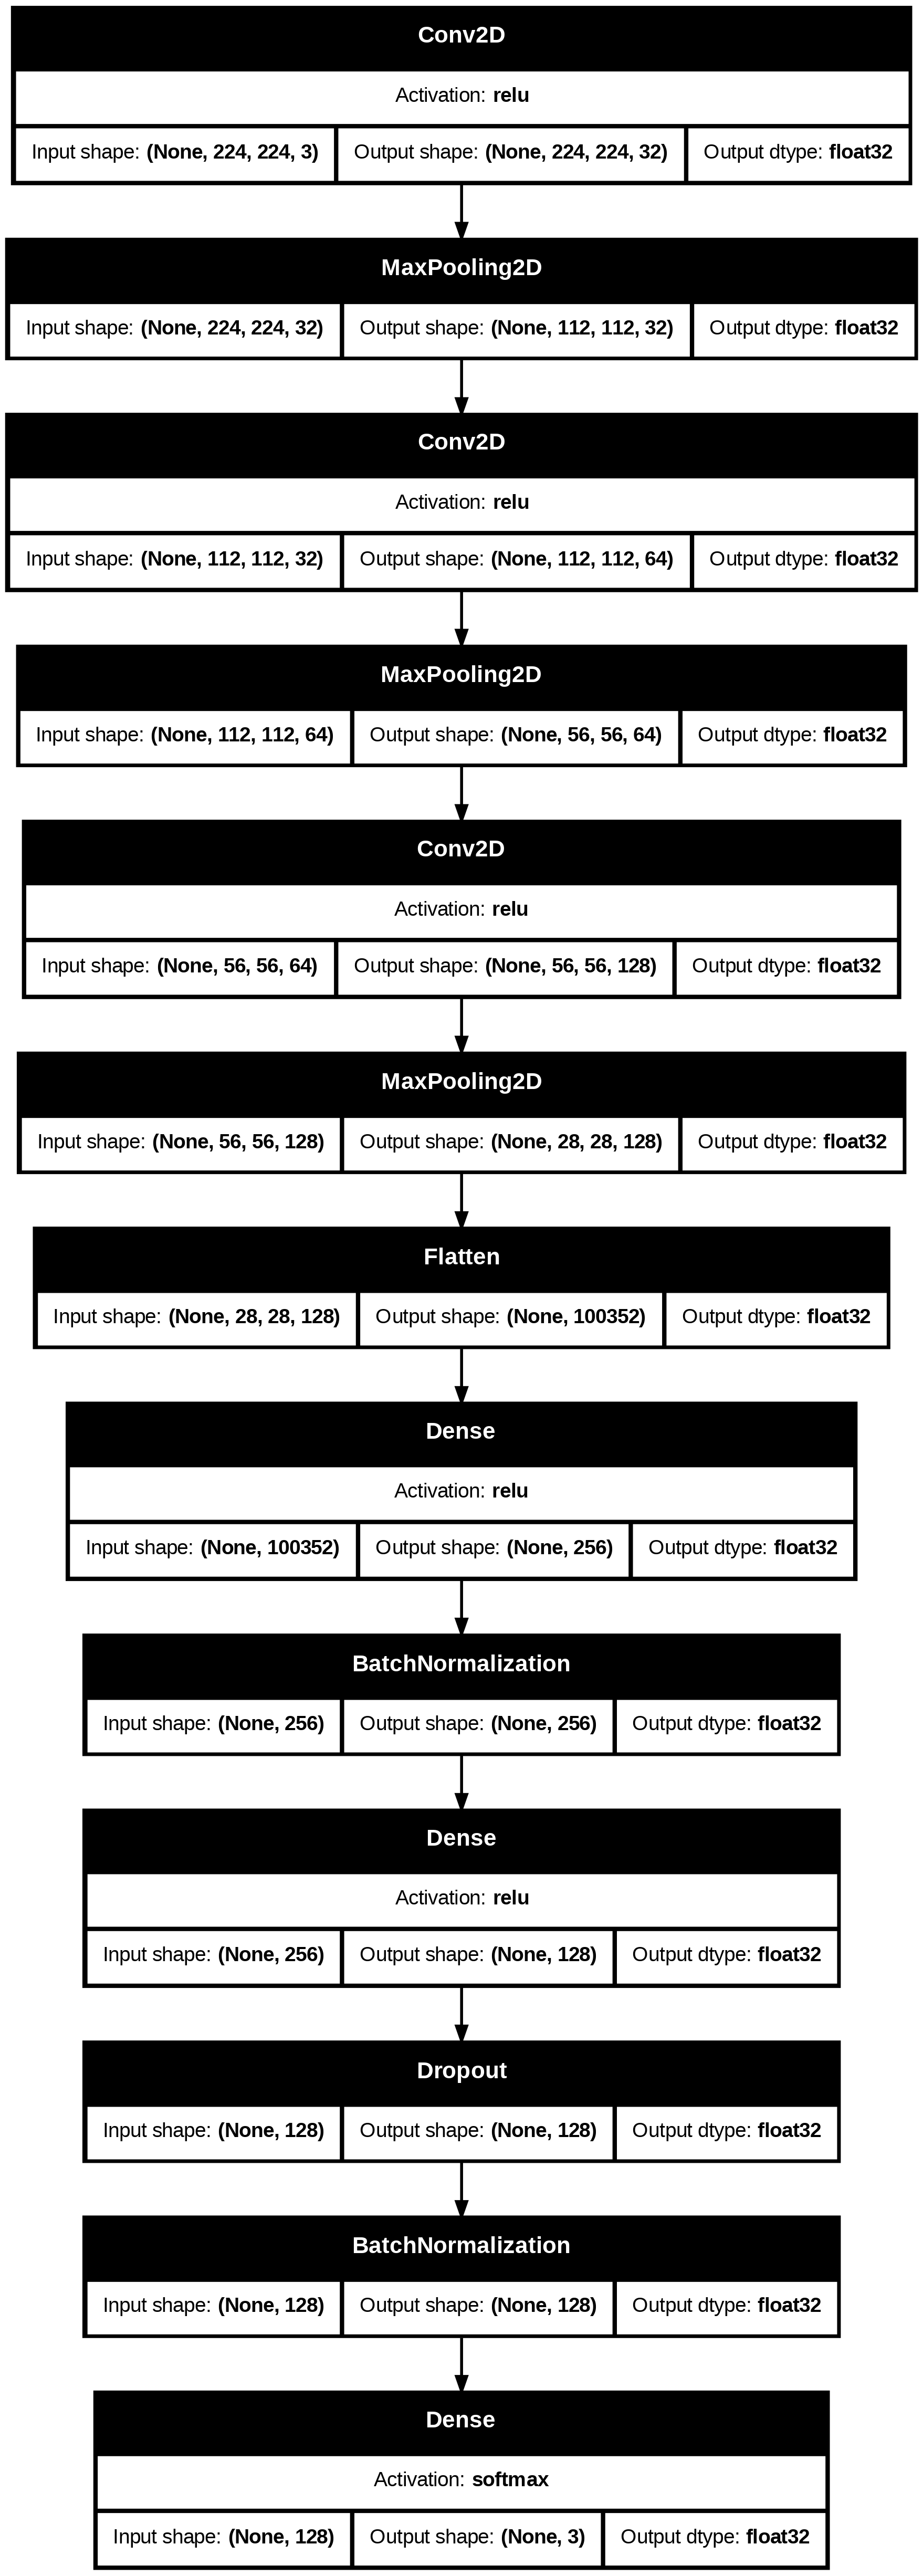

In [20]:
keras.utils.plot_model(
	sequential_cnn,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

In [21]:
sequential_cnn.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Dense name=dense_1, built=True>,
 <Dropout name=dropout, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Dense name=dense_2, built=True>]

In [22]:
first_conv_layer = sequential_cnn.layers[0]

In [23]:
weights, biases = first_conv_layer.get_weights()
weights

array([[[[ 6.14262074e-02, -5.80553040e-02,  6.07446283e-02, ...,
           1.44205987e-03,  1.30496249e-02,  4.93187457e-02],
         [ 2.21612453e-02,  5.86419106e-02,  2.76086181e-02, ...,
          -6.60827756e-02, -2.36178935e-03, -5.97501919e-02],
         [ 4.67918962e-02,  2.66998485e-02,  2.37318128e-03, ...,
          -7.15036392e-02, -5.05986325e-02,  6.48813695e-03]],

        [[-8.18303376e-02, -4.87236269e-02, -1.57881677e-02, ...,
          -1.21739656e-02,  5.79846948e-02, -6.48569316e-03],
         [ 2.14916021e-02,  2.45113075e-02, -7.94889033e-02, ...,
          -6.90905005e-02, -4.03886735e-02, -4.23543975e-02],
         [ 4.39423770e-02, -4.71158028e-02, -1.06259659e-02, ...,
           2.82544270e-02, -5.66456579e-02,  2.00350881e-02]],

        [[ 3.87420356e-02,  7.67694414e-03, -6.00278191e-02, ...,
           1.90483779e-02,  2.59098783e-02, -1.22670531e-02],
         [-9.39011574e-04,  1.60490125e-02, -5.16812764e-02, ...,
          -2.37235837e-02,  8.2415

In [24]:
weights.shape

(5, 5, 3, 32)

In [25]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [26]:
biases.shape

(32,)

In [27]:
sequential_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [28]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True

In [29]:
es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [30]:
history_sequential = sequential_cnn.fit(X_train_dl, y_train_dl,
					validation_data = (X_test_dl, y_test_dl),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - accuracy: 0.7875 - loss: 0.4962 - val_accuracy: 0.3423 - val_loss: 11.0087 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9009 - loss: 0.2505 - val_accuracy: 0.3423 - val_loss: 13.5434 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9247 - loss: 0.1917 - val_accuracy: 0.7977 - val_loss: 0.6480 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9363 - loss: 0.1566 - val_accuracy: 0.4973 - val_loss: 1.8466 - learning_rate: 0.0010
Epoch 5/10
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9450 - loss: 0.1365
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9450 - loss: 0.1364 - val_accuracy: 0.5600 - val_loss: 3.4239 - learning_rate: 0.0010
Epoch 6/10
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9631 - l

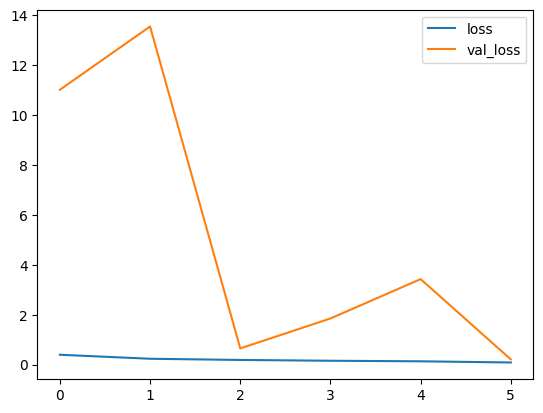

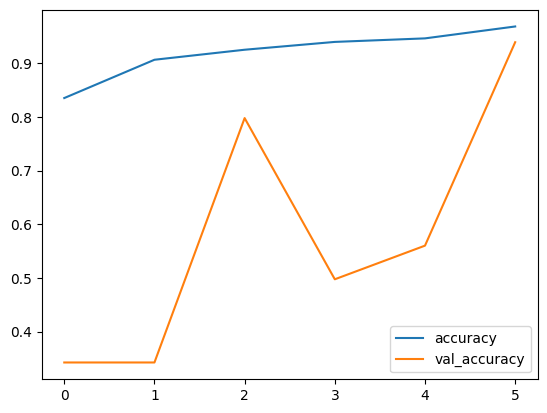

In [31]:
history_sequential_df = pd.DataFrame(history_sequential.history)
history_sequential_df.loc[:,['loss','val_loss']].plot()
history_sequential_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [32]:
sequential_cnn_pred_test = sequential_cnn.predict(X_test_dl)
y_test_dl_arg = np.argmax(y_test_dl, axis=1)
sequential_cnn_pred = np.argmax(sequential_cnn_pred_test, axis=1)
sequential_cnn_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


array([1, 0, 1, ..., 2, 0, 2])

In [33]:
cf_sequential_cnn_pred_test = confusion_matrix(y_test_dl_arg, sequential_cnn_pred)
cf_sequential_cnn_pred_test

array([[983,  44,   0],
       [  0, 893, 109],
       [  0,  30, 941]])

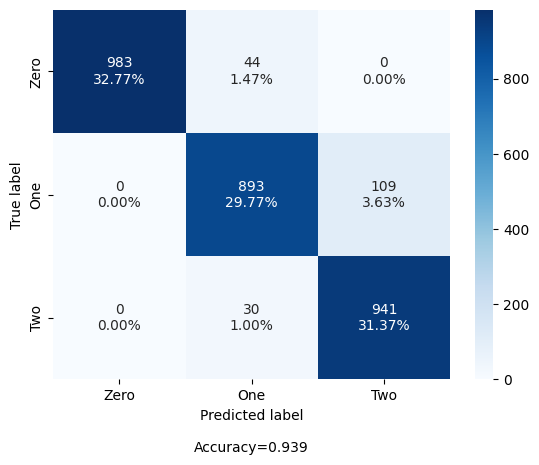

In [36]:
make_confusion_matrix(cf_sequential_cnn_pred_test, categories=categories, cmap="Blues")

## Transfer Learning

### Inception-V3 Architecture

In [45]:
inception_pretrained = InceptionV3(input_shape=(224,224,3),
                               weights='imagenet',
                               include_top=False)

In [46]:
# Freezing layers in convolutional base
inception_pretrained.trainable = False

# Custom classification block (see note 9, below)
x = layers.GlobalAveragePooling2D()(inception_pretrained.output)
x = layers.Dense(1, activation='sigmoid')(x)

In [47]:
# Compiling the model
inception = Model(inception_pretrained.input, x)
inception.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [48]:
history_inception = sequential_cnn.fit(X_train_dl, y_train_dl,
					validation_data = (X_test_dl, y_test_dl),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9754 - loss: 0.0627 - val_accuracy: 0.7653 - val_loss: 0.9289 - learning_rate: 5.0000e-04
Epoch 2/10
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9852 - loss: 0.0453
 Validation accuracy has reached upto 					90% so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9852 - loss: 0.0453 - val_accuracy: 0.9233 - val_loss: 0.2582 - learning_rate: 5.0000e-04


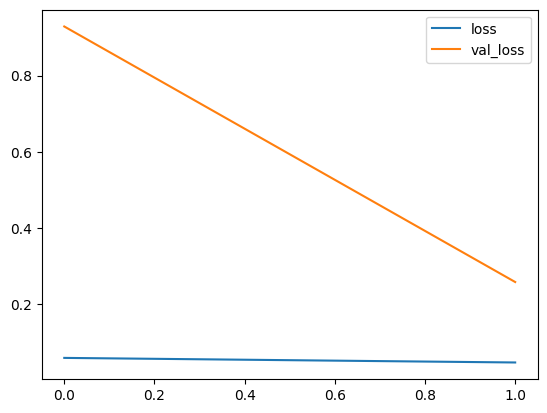

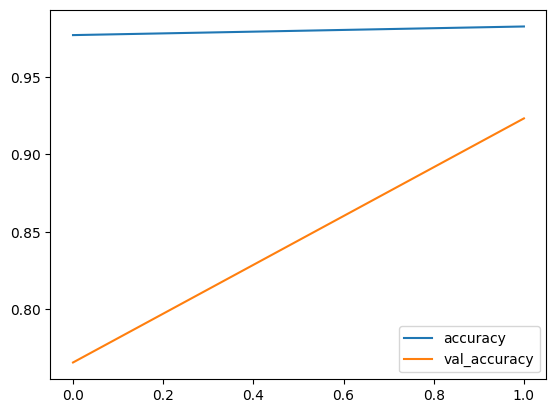

In [49]:
history_inception_df = pd.DataFrame(history_inception.history)
history_inception_df.loc[:,['loss','val_loss']].plot()
history_inception_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [55]:
inception_pred_test = inception.predict(X_test_dl)
inception_pred = np.argmax(inception_pred_test, axis=1)
inception_pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [56]:
cf_inception_pred_test = confusion_matrix(y_test_dl_arg, inception_pred)
cf_inception_pred_test

array([[1027,    0,    0],
       [1002,    0,    0],
       [ 971,    0,    0]])

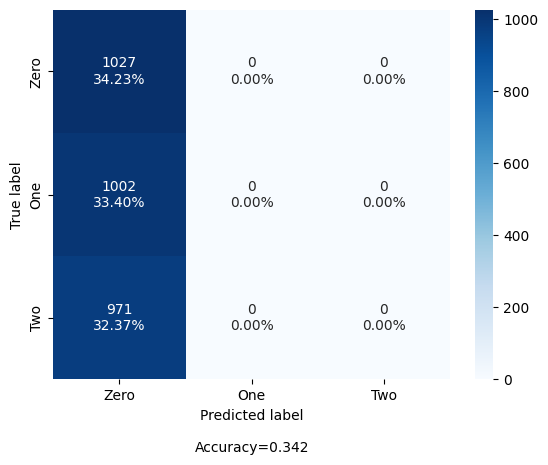

In [57]:
make_confusion_matrix(cf_inception_pred_test, categories=categories, cmap="Blues")

# Results & Discussion


In summary, we ran 3 experiments in which we used classical machine learning algorithms to train various supervised learning models for our image classification task.

Firstly, we experimented with Scikit-Learn's Logistic Regression classifier, training 3 Logistic Regression classifiers with L1, L2, and Elastic net regularization specifically. Our L1 regularization LR classifier yielded a test accuracy of 0.732, our L2 regularization LR classifier yielded a test accuracy of 0.758, and our Elastic net regularization LR classifier yielded a test accuracy of 0.773. We found the optimal hyperparameter to be L2 regularization through GridSearchCV which yielded a final test accuracy of 0.773. Although Logistic Regression has been historically known to not generalize well on image classification tasks, our Logistic Regression was able to predict with fair accuracy (although far from regulatory standards) whether a patient had normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Secondly, we experimented with Scikit-Learn's K-Nearest Neighbors classifier, training 3 K-Nearest Neighbors classifiers with K = 3, K = 4, and K = 5 specifically. Our K = 5 K-Nearest Neighbors classifier yielded a test accuracy of 0.543, our K = 3 K-Nearest Neighbors classifier yielded a test accuracy of 0.592, and our K = 4 K-Nearest Neighbors classifier yielded a test accuracy of 0.611. We found the optimal hyperparameter to be K = 2 through GridSearchCV which yielded a final test accuracy of 0.753. Although K-Nearest Neighbors has been historically known to generalize relatively well on image classification tasks, our K-Nearest Neighbors classifiers underperformed compared to our Logistic Regression classifiers to predict whether a patient had normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Lastly, we experimented with Scikit-Learn's Support Vector Machine classifier, training 3 Support Vector Machine classifiers with kernel = 'linear' and C = 5, kernel = 'poly' and C = 5, and kernel = 'rbf' and C = 0.001 specifically. Our kernel = 'linear' and C = 5 SVM classifier yielded a test accuracy of 0.783, our kernel = 'poly' and C = 5 SVM classifier yielded a test accuracy of 0.907, and our kernel = 'rbf' and C = 0.001 SVM classifier yielded a test accuracy of 0.324. We found the optimal hyperparameter to be kernel = 'rbf' and C = 5 through GridSearchCV which yielded a final test accuracy of 0.922. Our best SVM classifier w kernel = 'rbf' and C = 5 achieved a final test accuracy of 0.922 to  predict whether a patient had normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs which could be a potential candidate for an computer-aided diagnostic tool for lung cancer detection.

We then ran 2 experiments in which we used deep learning algorithms to train various supervised learning models for our image classification task.

Firstly, using Keras's Sequential API, we architected a Baseline Sequential Convolutional Neural Network (CNN) with 3 convolutional layers, 3 max pooling layers, 3 fully-connected / dense layers, a flattening layer, 2 batch normalization layers, and a dropout layer. From our Epoch vs. Loss and Validation Loss chart, we can see that as the epochs rise, the loss decreases minimally while the validation loss decreases minimally around epoch 5 and then drastically rises. From our Epoch vs. Accuracy and Validation Accuracy chart, we can see that our Baseline Sequential CNN has not overfitted as the differential between the training and validation accuracy after 3 epochs became minimally low. With our Baseline Sequential CNN, we achieved a final test accuracy of 0.939 to predict whether a patient had normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs which could make for an event better candidate for an computer-aided diagnostic tool for lung cancer detection.

Lastly, using the Pre-trained Inception-V3 CNN, we employed transfer learning for our particular image classification task on by finetuning this pre-trained model on our training image dataset. From our Epoch vs. Loss and Validation Loss chart, we can see that as the epochs rise, the loss decreases to a minimum while the validation loss consistently decreases as well. From our Epoch vs. Accuracy and Validation Accuracy chart, we can see that our finetuned Inception-V3 CNN does not seem to have overfitted as the differential between the validation accuracy began rising to near that of our training accuracy. However, due to possibly incorrect finetuning, data preparation, or some other training error, our finetuned Inception-V3 model classified all of our training samples as patients with normal lungs across CT scans of all the patients' lungs. Our finetuned Inception-V3 model would not make for an accurate computer-aided diagnostic tool for lung cancer detection.

# Evaluation & Reflection

In retrospect, from my experiments, I conclude that Logistic Regression classification performance isn't optimal but doesn't underperform significantly for our image classification task. From my Support Vector Machine classification experiment, I was pleasntly surprised by how accurate my Support Vector Machines were able to correctly classify lung cancers from patients' CT scans (albeit the training time taking much longer than I would like, they took longer to train than my CNNs). My Baseline Sequential CNN performed even better achieving a final test accuracy of 93.9% correctness on whether patients' had carcinomic lung cells based on CT scans. Unfotunately, K-Nearest Neighbors classifiers did not fare as well on this image classification task as I would envision. Furthermore, finetuning an Inception-V3 model to our classification task was not able to generalize well and, in fact, classified all CT scans as having normal lungs.

In reflection, what I would like to do differently for my project given the time, I would like to experiment with more hyperparameters for each of my classical machine learning algorithms and have a bigger hyperparameter space for GrisSearchCV to find the optimal set of hyperparameters and best model for each ML algorithm. I would also like to get to the bottom of why finetuning the pre-trained Inception-V3 model did not perform to the standard I wanted to and get it to classify CT scans of patients' more accurately.

# References

[1] https://www.cancer.org/cancer/types/lung-cancer/about/key-statistics.html?fbclid=IwY2xjawFDgXBleHRuA2FlbQIxMAABHSYVv6NCFSq1IngxaU3MvkYSU2aUa_q22e3jwk5mRBaoziLtqzf-lpdorw_aem_tapfACi98WHdURdM9Ss5iQ

[2] https://www.aamc.org/news/press-releases/new-aamc-report-shows-continuing-projected-physician-shortage#:~:text=According%20to%20new%20projections%20published,to%2086%2C000%20physicians%20by%202036.

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10025752/?fbclid=IwY2xjawFDghJleHRuA2FlbQIxMAABHbgMFLVw4uNxTWOxXjjaSaVLv3A0XYFOU8Wi5527COjHI90PToUnn7zHHg_aem_gOvhyuiY9S9F3gNVpjb5sA

[4] https://www.geeksforgeeks.org/lung-cancer-detection-using-convolutional-neural-network-cnn/

[5] Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019